# Systems of ODEs and Higher Order ODEs

**References:**

- Section 6.3 *Systems of Ordinary Differential Equations* in {cite}`Sauer`, to Sub-section 6.3.1 *Higher order equations*.
- Section 5.9 *Higher Order Equations and Systems of Differential Equations* in {cite}`Burden-Faires`.

The short version of this section is that the numerical methods and algorithms developed so for for the initial value problem

$$
\begin{split}
\frac{d u}{d t} &= f(t, u(t)), \quad a \leq t \leq b
\\
u(a) &= u_0
\end{split}
$$

all also work for system of first order ODEs by simply letting $u$ and $f$ be vector-valued,
and for that, the Python code requires only one small change.

Also, higher order ODE's (and systems of them) can be converted into systems of first order ODEs.

## Converting a second order ODE to a first order system

To convert 

$$ y'' = f(t, y, y') $$

with initial conditions

$$ y(a) = y_0, \; y'(a) = v_0 $$

to a first order system, introduction the two functions

$$
\begin{split}
u_1(t) &= y(t)
\\
u_2(t) &= \frac{d y}{d t}, = u_1'(t)
\end{split}
$$

Then

$$ y'' = u_1' = f(t, u_0, u_1) $$

and combining with the definition of $u_1$ gives the system

$$
\begin{split}
u_0' &= u_1
\\
u_1' &= f(t, u_0, u_1)
\\
&\text{with initial conditions}
\\
u_0(a) &= y_0
\\
u_1(a) &= v_0
\end{split}
$$

Next this can be put into vector form.
Defining the vector-valued functions

$$
\begin{split}
\tilde{u}(t) &= \langle u_1(t), u_2(t) \rangle
\\
\tilde{f}(t, \tilde{u}(t)) &= \left\langle u_1(t), f(t, u_2(t), u_2(t)) \right\rangle
\end{split}
$$

and initial data vector

$$\tilde{u}_0 = \langle u_{0,1}, u_{0,2} \rangle = \langle y_0, v_0 \rangle$$

puts the equation into the form

$$
\begin{split}
\frac{d \tilde{u}}{d t} &= \tilde{f}(t, \tilde{u}(t)), \quad a \leq t \leq b
\\
\tilde{u}(a) &= \tilde{u}_0
\end{split}
$$

$$
\begin{split}
\frac{d \tilde{u}}{d t} &= \tilde{f}(t, \tilde{u}(t)), \quad a \leq t \leq b
\\
\tilde{u}(a) &= \tilde{u}_0
\end{split}
$$

## Test Cases

In this and subsequent sections, numerical methods for higher order equations and systems will be compared using several equations seen in
{ref}`the first section of this chapter <ode-examples>`:

- {prf:ref}`ode-damped-mass-spring` $\displaystyle M \frac{d^2 u}{d t^2} = -K u - D \frac{d u}{d t}$ (a Mass-Spring System).

- {prf:ref}`ode-freely-rotating-pendulum` $M L \theta'' = -M g\sin\theta - D L \theta'$ (The Freely Rotating Pendulum).

%- {prf:ref}`ode-fast-slow` $u'' + (K+1) u' + K u = 0$ (with fast and slow time scales for large $K$).

In [1]:
using PyPlot
include("NumericalMethods.jl")
using .NumericalMethods: approx4

The Euler's method code from before does not quite work, but only slight modification is needed;
that "scalar" version

In [2]:
function eulermethod(f, a, b, u_0, n)    
    h = (b-a)/n
    t = range(a, b, n+1)
    U = zeros(n+1)
    U[1] = u_0
    for i in 1:n
        U[i+1] = U[i] + f(t[i], U[i])*h
    end
    return (t, U)
end;

becomes 

In [3]:
function eulermethod_system(f, a, b, u_0, n)
    # TO DO: one could use multiple dispatch to keep the name "eulermethod".
    # The conversion for the system version is mainly "U[i] -> U[i,:]"
    
    h = (b-a)/n
    t = range(a, b, n+1)
    
    # The following three lines and the one in the for loop below change for the system version
    n_unknowns = length(u_0)
    U = zeros(n+1, n_unknowns)
    U[1,:] = u_0  # Only for system version

    for i in 1:n
        U[i+1,:] = U[i,:] + f(t[i], U[i,:])*h  # For the system version
    end
    return (t, U)
end;

**Note.** Here and below, these notes follow the convention of using lowercase letters for exact solutions; uppercase for numerical approximations.

## Solving the Damped Mass-Spring System
({prf:ref}`ode-damped-mass-spring`)

In [4]:
f_mass_spring(t, u) = [ u[2], -(K/M)*u[1] - (D/M)*u[2] ];

In [5]:
E_mass_spring(y, Dy) = (K * y^2 + M * Dy^2)/2;

In [6]:
function y_mass_spring(t; t_0, u_0, K, M, D)
    (y_0, v_0) = u_0
    discriminant = D^2 - 4K*M
    if discriminant < 0  # underdamped
        omega = sqrt(4K*M - D^2)/(2M)
        A = y_0
        B = (v_0 + y_0*D/(2M))/omega
        return exp(-D/(2M)*(t-t_0)) * ( A*cos(omega*(t-t_0)) + B*sin(omega*(t-t_0)))
    elseif discriminant > 0  # overdamped
        Delta = sqrt(discriminant)
        lambda_plus = (-D + Delta)/(2M)
        lambda_minus = (-D - Delta)/(2M)
        A = M*(v_0 - lambda_minus * y_0)/Delta
        B = y_0 - A
        return A*exp(lambda_plus*(t-t_0)) + B*exp(lambda_minus*(t-t_0))
    else
        lambda = -D/(2M)
        A = y_0
        B = v_0 - A * lambda
        return (A + B*t)*exp(lambda*(t-t_0))
    end
end;

In [7]:
function damping(K, M, D)
    if D == 0
        println("Undamped")
    else
        discriminant = D^2 - 4K*M
        if discriminant < 0
            println("Underdamped")
        elseif discriminant > 0
            println("Overdamped")
        else
            println("Critically damped")
        end
    end
end;

The above functions are available in module `NumericalMethods`;
they will be used in later sections.

### First solve without damping, so the solutions have sinusoidal solutions

Note: the orbits go clockwise for undamped (and underdamped) systems.

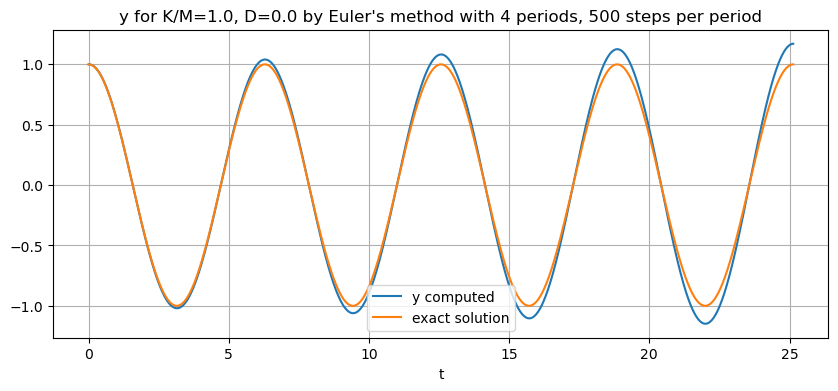

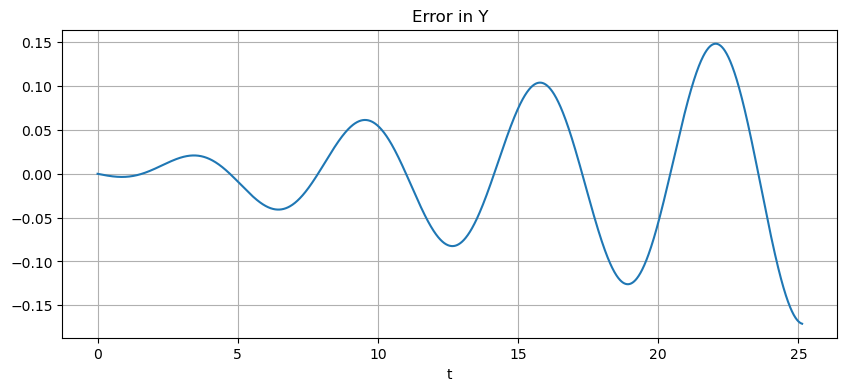

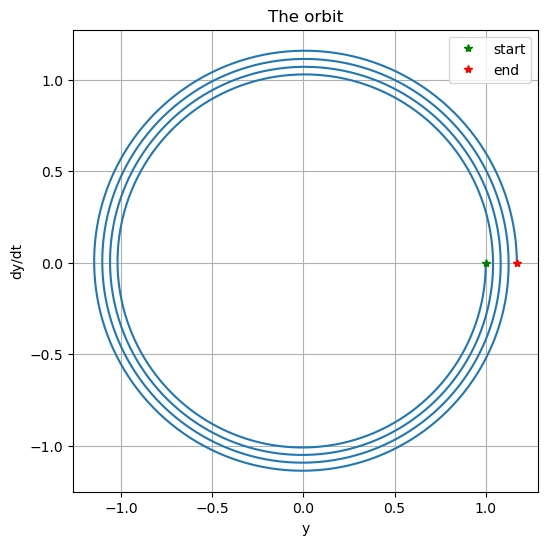

In [8]:
M = 1.0
K = 1.0
D = 0.0
y_0 = 1.0
Dy_0 = 0.0
u_0 = [y_0, Dy_0]
a = 0.0
periods = 4
b = 2pi * periods

stepsperperiod = 500
n = Int(stepsperperiod * periods)

(t, U) = eulermethod_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,4])
title("y for K/M=$(K/M), D=$D by Euler's method with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

# Phase plane diagram; for D=0 the exact solutions are ellipses (circles if M = k)
figure(figsize=[6,6])  # Make axes equal length; orbits should be circular or "circular spirals" 
title("The orbit")
plot(Y, DY)
xlabel("y")
ylabel("dy/dt")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

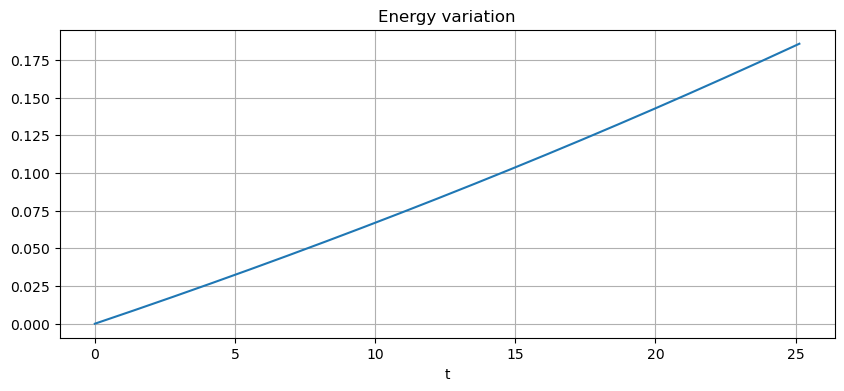

In [9]:
figure(figsize=[10,4])
E_0 = E_mass_spring(y_0, Dy_0)
E = E_mass_spring.(Y, DY)
title("Energy variation")
plot(t, E .- E_0)
xlabel("t")
grid(true)

### Next solve with damping

Underdamped


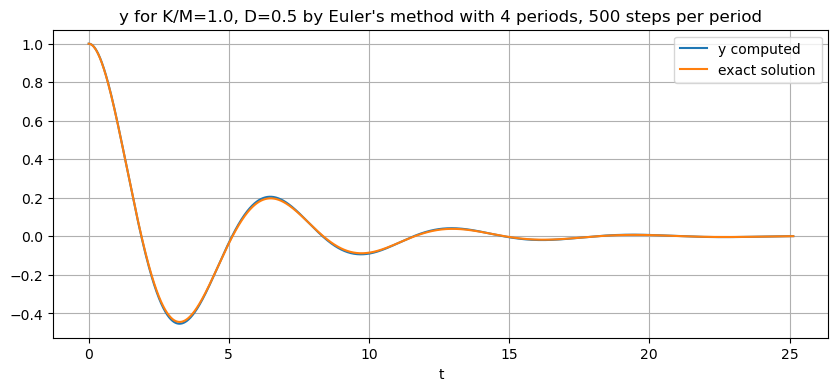

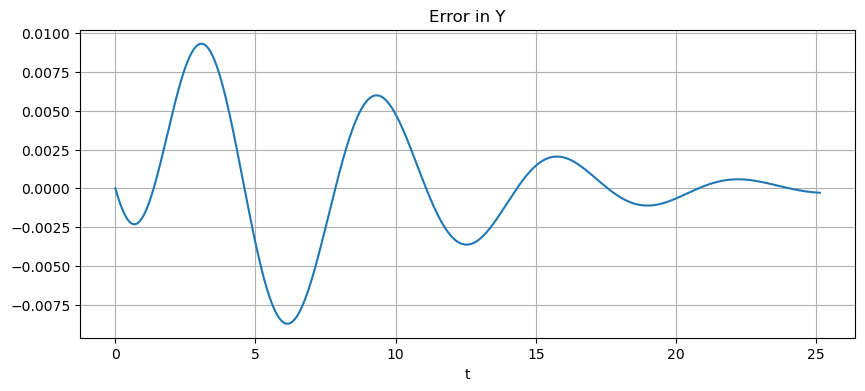

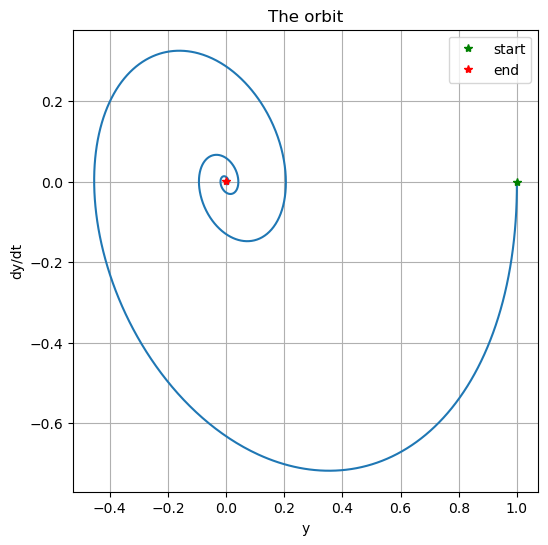

In [10]:
D = 0.5 # Underdamped: decaying oscillations
#D = 2 # Critically damped
#D = 2.1 # Overdamped: exponential decay

periods = 4
b = 2pi * periods

stepsperperiod = 500
n = Int(stepsperperiod * periods)

(t, U) = eulermethod_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

damping(K, M, D)

figure(figsize=[10,4])
title("y for K/M=$(K/M), D=$D by Euler's method with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

# Phase plane diagram; for D=0 the exact solutions are ellipses (circles if M = K)
figure(figsize=[6,6])  # Make axes equal length; orbits should be circular or "circular spirals" 
title("The orbit")
plot(Y, DY)
xlabel("y")
ylabel("dy/dt")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

## The "Classical" Runge-Kutta Method, Extended to Systems of Equations

As above, the previous "scalar" function for this method needs just three lines of code modified.

Before:

In [11]:
function rungekutta(f, a, b, u_0, n)
    # Use the (classical) Runge-Kutta Method to solve
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0
    
    h = (b-a)/n
    t = range(a, b, n+1)
    u = zeros(length(t))
    u[1] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i])*h
        K_2 = f(t[i]+h/2, u[i]+K_1/2)*h
        K_3 = f(t[i]+h/2, u[i]+K_2/2)*h
        K_4 = f(t[i]+h, u[i]+K_3)*h
        u[i+1] = u[i] + (K_1 + 2*K_2 + 2*K_3 + K_4)/6
    end
    return (t, u)
end;

After:

In [12]:
function rungekutta_system(f, a, b, u_0, n)
    # Use the (classical) Runge-Kutta Method to solve
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0
    # The conversion for the system version is mainly "u[i] -> u[i,:]"

    h = (b-a)/n
    t = range(a, b, n+1)
    n_unknowns = length(u_0)
    u = zeros(n+1, n_unknowns)
    u[1,:] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i,:])*h
        K_2 = f(t[i]+h/2, u[i,:]+K_1/2)*h
        K_3 = f(t[i]+h/2, u[i,:]+K_2/2)*h
        K_4 = f(t[i]+h, u[i,:]+K_3)*h
        u[i+1,:] = u[i,:] + (K_1 + 2*K_2 + 2*K_3 + K_4)/6
    end
    return (t, u)
end;

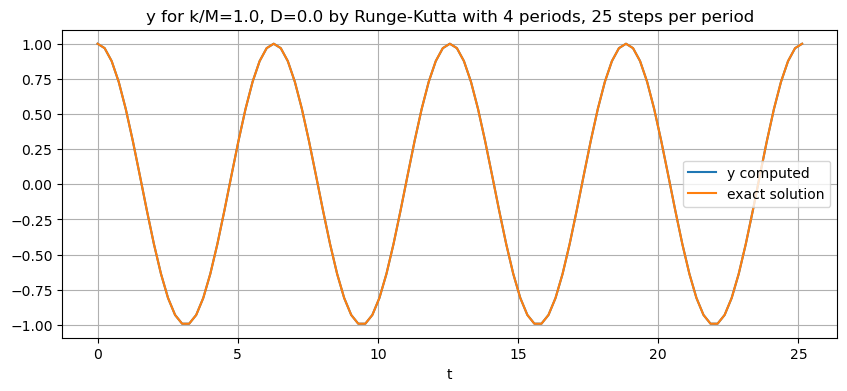

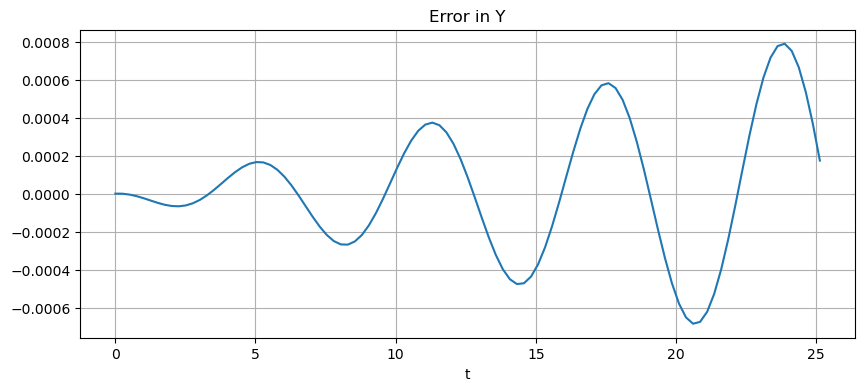

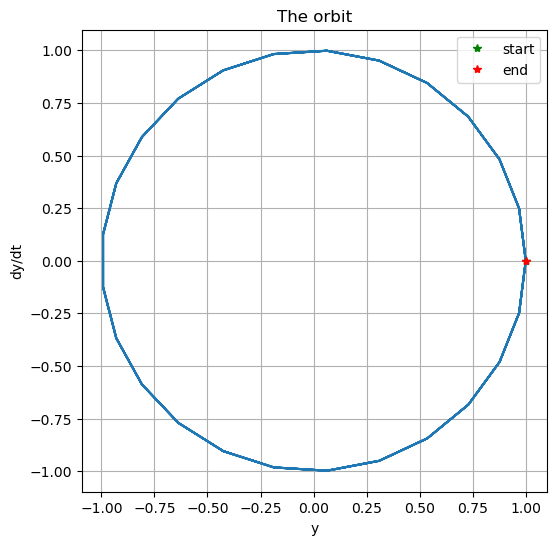

In [13]:
M = 1.0
k = 1.0
D = 0.0
u_0 = [1.0, 0.0]
a = 0.0
periods = 4
b = 2pi * periods

stepsperperiod = 25
n = stepsperperiod * periods

(t, U) = rungekutta_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

figure(figsize=[10,4])
title("y for k/M=$(k/M), D=$D by Runge-Kutta with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

# Phase plane diagram; for D=0 the exact solutions are ellipses (circles if M = k)
figure(figsize=[6,6])  # Make axes equal length; orbits should be circular or "circular spirals" 
title("The orbit")
plot(Y, DY)
xlabel("y")
ylabel("dy/dt")
plot(Y[1], DY[1], "g*", label="start")
plot(Y[end], DY[end], "r*", label="end")
legend()
grid(true)

Underdamped


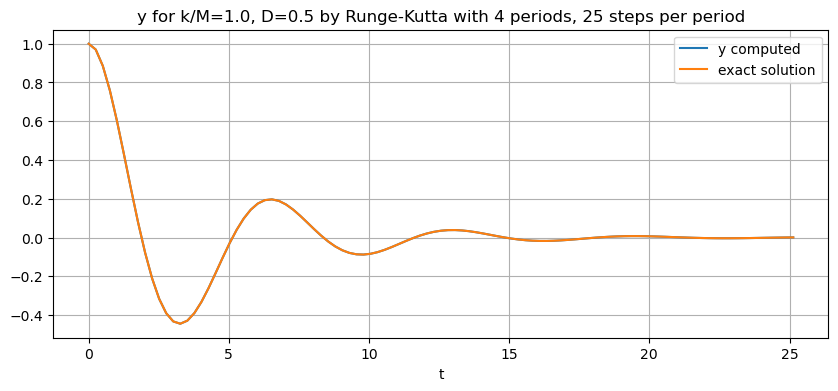

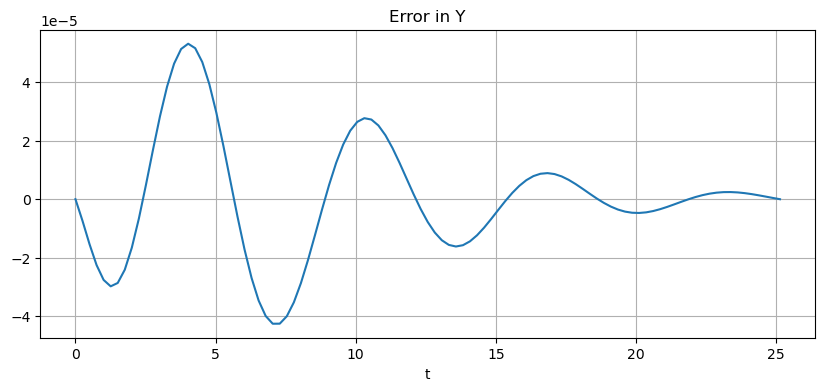

In [14]:
D = 0.5 # Underdamped: decaying oscillations
#D = 2 # Critically damped
#D = 2.1 # Overdamped: exponential decay

periods = 4
b = 2pi * periods

stepsperperiod = 25
n = Int(stepsperperiod * periods)

(t, U) = rungekutta_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

damping(k, M, D)

figure(figsize=[10,4])
title("y for k/M=$(k/M), D=$D by Runge-Kutta with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

## Solving the Freely Rotating Pendulum Equation
({prf:ref}`ode-freely-rotating-pendulum`)

For now, this is just briefly explored as a cautionary tail of what can happen when slight changes in the system lead to qualitatively very different solution behavior.
So we will look at a few examples for the conservative case $D=0$, close to the separatrix solutions noted above.

Parameters can all be scaled away to $M = L = g = 1$ so the critical energy is $Mg = 1$.

In [15]:
f_pendulum(t, u) = [ u[2], -(g/L)*sin(u[1]) ];

In [16]:
M = g = L = 1.0;
E_0 = 1.0  # Separatrix
#E_0 = 0.999
#E_0 = 1.001

theta_0 = 0.0
omega_0 = sqrt(2(E_0 + M*g*cos(theta_0))/(M*L));
u_0 = [theta_0, omega_0]

a = 0.0

#periods = 8  # periods of the linear approximation, "sin(theta) = theta"
#b = 2pi * sqrt(L/g) * periods

b = 80.0
b = 20.;

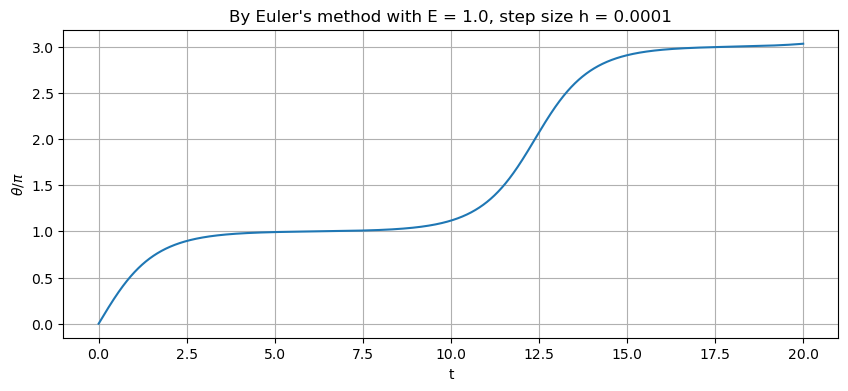

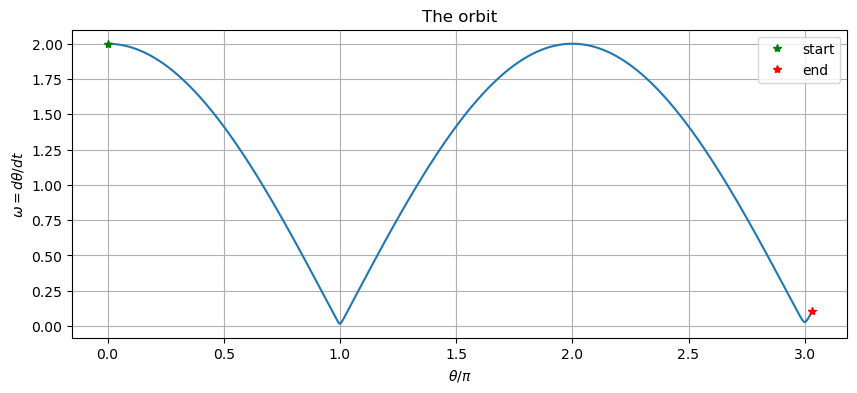

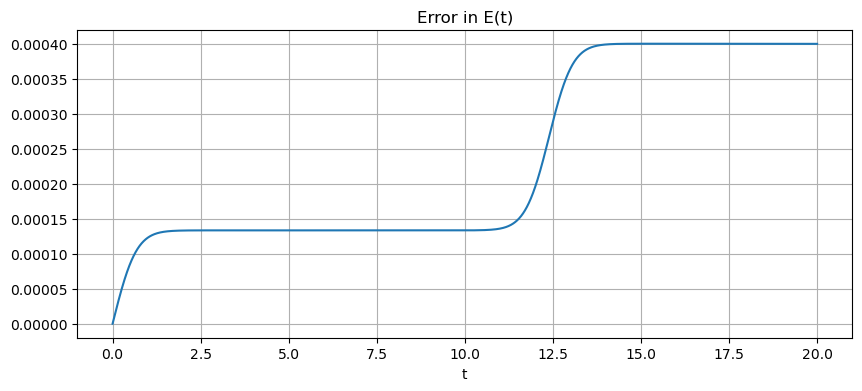

In [17]:
#stepsperperiod = 1_000
#n = Int(stepsperperiod * periods)
#h = (b-a)/n

stepsperunittime = 10_000
h = 1/stepsperunittime
n = Int(round((b-a)/h))

(t, U) = eulermethod_system(f_pendulum, a, b, u_0, n)
theta = U[:,1]
omega = U[:,2]

figure(figsize=[10,4])
title("By Euler's method with E = $E_0, step size h = $(approx4(h))")
plot(t, theta/pi, label="theta")
xlabel("t")
ylabel(L"\theta/\pi")
grid(true)

# Phase plane diagram
figure(figsize=[10,4])
title("The orbit")
plot(theta/pi, omega)
xlabel(L"\theta/\pi")
ylabel(L"\omega = d\theta/dt")
plot(theta[1]/pi, omega[1], "g*", label="start")
plot(theta[end]/pi, omega[end], "r*", label="end")
legend()
grid(true)

# Error in the (conserved) energy E
figure(figsize=[10,4])
E = (M*L/2) * omega.^2 - M*g*cos.(theta)
E_error = E .- E_0
title("Error in E(t)")
plot(t, E_error, label="theta")
xlabel("t")
#ylabel(L"\theta/\pi")
grid(true)

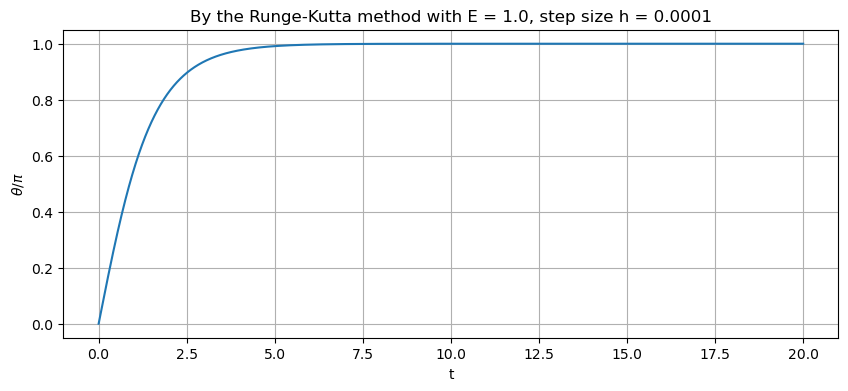

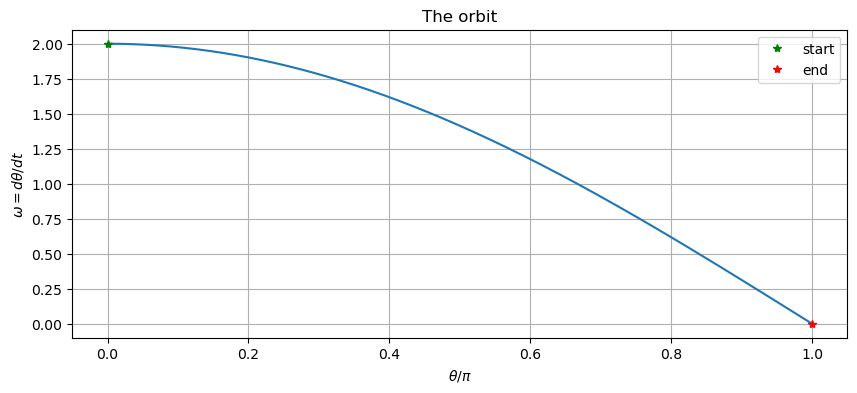

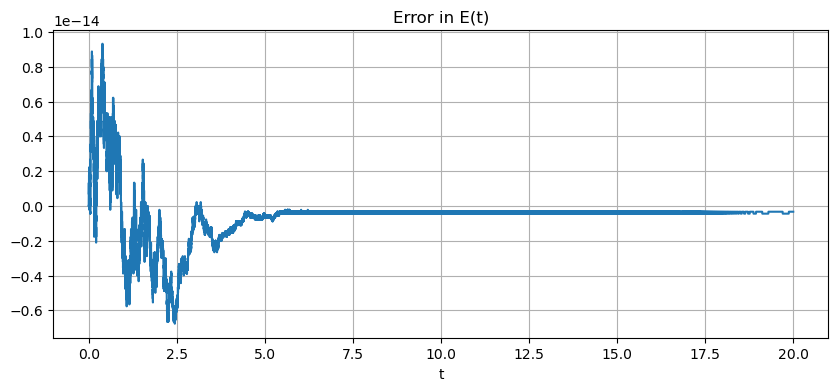

In [18]:

#stepsperperiod = 10_000
#n = Int(stepsperperiod * periods)
#h = (b-a)/n

stepsperunittime = 25
stepsperunittime = 10_000
h = 1/stepsperunittime
n = Int(round((b-a)/h))

(t, U) = rungekutta_system(f_pendulum, a, b, u_0, n)
theta = U[:,1]
omega = U[:,2]

figure(figsize=[10,4])
title("By the Runge-Kutta method with E = $E_0, step size h = $(approx4(h))")
plot(t, theta/pi, label="theta")
xlabel("t")
ylabel(L"\theta/\pi")
grid(true)

# Phase plane diagram
figure(figsize=[10,4])
title("The orbit")
plot(theta/pi, omega)
xlabel(L"\theta/\pi")
ylabel(L"\omega = d\theta/dt")
plot(theta[1]/pi, omega[1], "g*", label="start")
plot(theta[end]/pi, omega[end], "r*", label="end")
legend()
grid(true)

# Error in the (conserved) energy E
E = (M*L/2) * omega.^2 - M*g*cos.(theta)
E_error = E .- E_0
figure(figsize=[10,4])
title("Error in E(t)")
plot(t, E_error, label="theta")
xlabel("t")
#ylabel(L"\theta/\pi")
grid(true);

## Appendix: the Explicit Trapezoid and Midpoint Methods for systems

Yet again, the previous functions for these methods need just three lines of code modified.

The demos are just for the non-dissipative case, where the solution is known to be $y = \cos t$, $dt/dt = -\sin t$.

For a fairer comparison of "accuracy vs computational effort" to the Runge-Kutta method,
twice as many time steps are used so that the same number of function evaluations are used for these three methods.

In [19]:
function explicittrapezoid_system(f, a, b, u_0, n)
    # Use the Explict Trapezoid Method (a.k.a Improved Euler) to solve the system
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0 
    # The conversion for the system version is mainly "u[i] -> u[i,:]"

    h = (b-a)/n
    t = range(a, b, n+1)
    n_unknowns = length(u_0)
    u = zeros(n+1, n_unknowns)
    u[1,:] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i,:])*h
        K_2 = f(t[i]+h, u[i,:]+K_1)*h
        u[i+1,:] = u[i,:] + (K_1 + K_2)/2.0
    end
    return (t, u)
end;

Underdamped
Underdamped


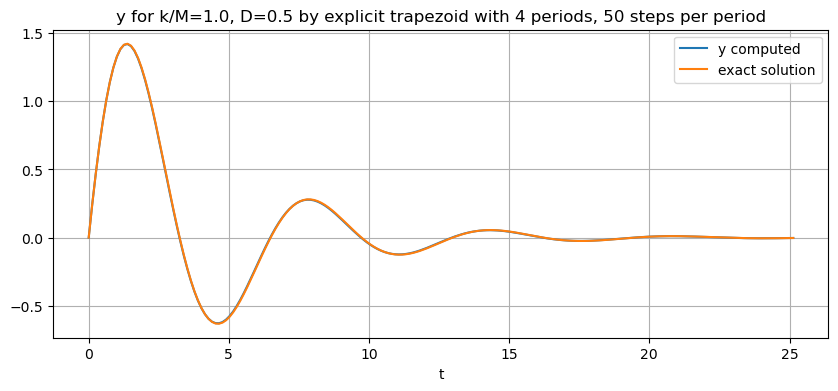

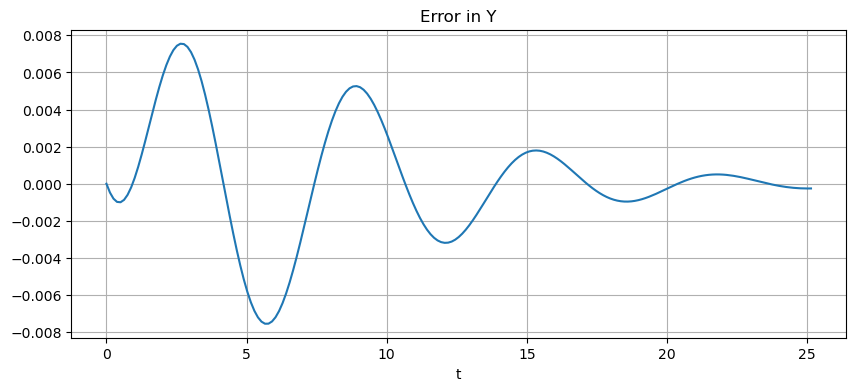

In [20]:
D = 0.5 # Underdamped: decaying oscillations
#D = 2 # Critically damped
#D = 2.1 # Overdamped: exponential decay

periods = 4
b = 2pi * periods

stepsperperiod = 50
n = Int(stepsperperiod * periods)

damping(k, M, D)

(t, U) = explicittrapezoid_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

damping(k, M, D)

figure(figsize=[10,4])
title("y for k/M=$(k/M), D=$D by explicit trapezoid with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)

At first glance this is doing well, keeping the orbits circular.
However, note the discrepancy between the start and end points:
these should be the same, as they are (visually) with the Runge-Kutta method.

In [21]:
function explicitmidpoint_system(f, a, b, u_0, n)
    # Use the Explict Midpoint Method (a.k.a Modified Euler) to solve the system
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0 
    # The conversion for the system version is mainly "u[i] -> u[i,:]"

    h = (b-a)/n
    t = range(a, b, n+1)
    n_unknowns = length(u_0)
    u = zeros(n+1, n_unknowns)
    u[1,:] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i,:])*h
        K_2 = f(t[i]+h/2, u[i,:]+K_1/2)*h
        u[i+1,:] = u[i,:] + K_2
    end
    return (t, u)
end;

Underdamped
Underdamped


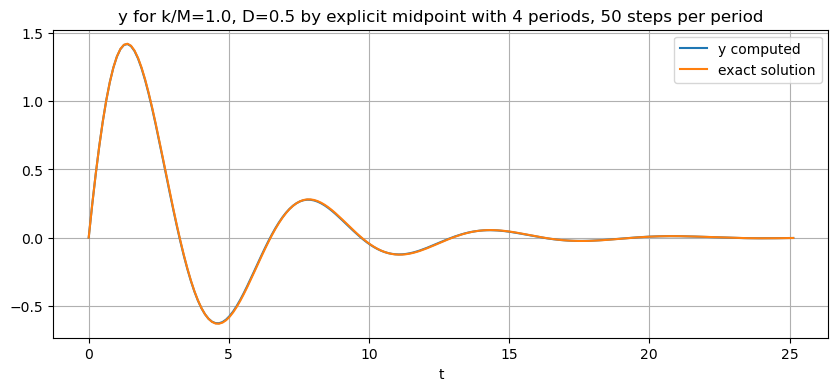

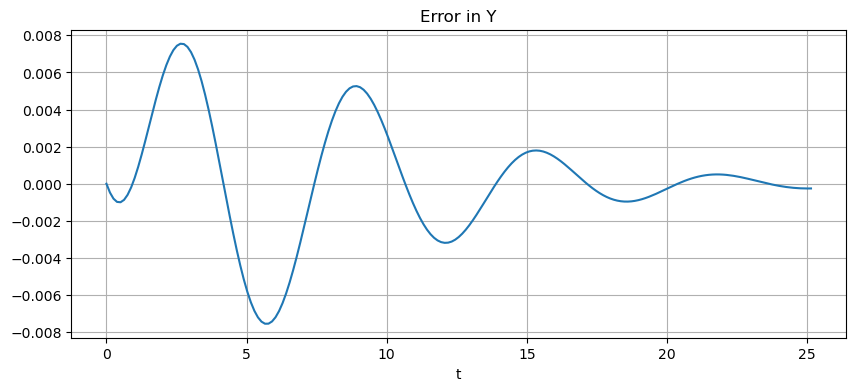

In [22]:
D = 0.5 # Underdamped: decaying oscillations
#D = 2 # Critically damped
#D = 2.1 # Overdamped: exponential decay

periods = 4
b = 2pi * periods

stepsperperiod = 50
n = Int(stepsperperiod * periods)

damping(k, M, D)

(t, U) = explicitmidpoint_system(f_mass_spring, a, b, u_0, n)
Y = U[:,1]
DY = U[:,2]
y = y_mass_spring.(t; t_0=a, u_0=u_0, K=K, M=M, D=D)  # Exact solution

damping(k, M, D)

figure(figsize=[10,4])
title("y for k/M=$(k/M), D=$D by explicit midpoint with $periods periods, $stepsperperiod steps per period")
plot(t, Y, label="y computed")
plot(t, y, label="exact solution")
xlabel("t")
legend()
grid(true)

figure(figsize=[10,4])
title("Error in Y")
plot(t, y-Y)
xlabel("t")
grid(true)